## Final Project Submission

Please fill out: 
* Student name: David Bartholomew
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


# Multiple Linear Regression: Predicting King County, WA, Housing Prices

This project involes an iterative approach to building a multiple linear regression model to predict sale prices for houses in King County, WA, utilizing data of homes sold in 2014 and 2015. The first portion of this project is spent cleaning the data (provided by Flatiron School), engineering a few new features, and then building models, tweaking each model until a final model is built. Rather than using log transformations to normalize data, I decided to keep the model as interpretable as possible, using alternative techniques to normalize residuals. As a result, I narrowed down the data to predict homes under 900k, favoring predictions for middle class families. Below is a list of all models built and general description of changes between each model:

### 1. Model 1: Using All Features
Our first model has an adjusted r-squared of .736, but residuals were not normal, violating our assumption of normality.

### 2. Model 2: Normalizing the Dependent Variable
Removing outliers and reducing our dependent variable brought down our r-squared to .723, but our residuals are much closer to a normal distribution. There are still several insignificant p-values, but prior to dealing with those I dealt with potential multicollinearity first.

### 3. Model 3: Dealing with Multicollinearity
Using a VIF (variance inflation factor), I removed two features that had a VIF using a VIF of 5 as my cutoff. After removing these features, the adjusted R squared stayed the same at .723, but there were still insignificant features.

### 4. Model 4: Removing Insignificant Features
After removing features with a p-value over 0.05, the adjusted r-squared stayed at .723. The next model deals with refining features by removing outliers.

### 5. Model 5: Refining Features
After removing outliers and removing certain features, our adjusted r-squared is now at .722. There are most certainly interactions among features, so we create interaction terms in our next model.

### 6. Model 6: Dealing with Interactions
Using combinations, I created a list of top interactions, and created two interaction terms as a result of this list and rebuilt a model with an adjusted r-squared of .757. Along with sqft_lot15 being insignificant at this point, another issue was the bedrooms had a positive correlation to price but a negative coefficient, so I decided to drop this feature in order to make my model more interpretable.

### 7. Model 7: Final Model
After dropping bedrooms and sqft_lot15, the final model had an adjusted r-squared of .756, and all p-values were significant.

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from scipy.stats import pearsonr
from itertools import combinations
%matplotlib inline

/Users/dbarth411/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Import and preview the data
df = pd.read_csv('kc_house_data.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

None

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#Preview data statistics
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
#Drop id column as it isn't relevant for our analysis
df.drop(columns=['id'], axis=1, inplace=True)

In [5]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [6]:
#Find missing values
df.isnull().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [8]:
#Fill missing values for waterfront
df.waterfront.fillna(0.0, inplace=True)

In [9]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [10]:
df.view.fillna(0.0, inplace=True)

In [11]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
652.0         1
1481.0        1
1245.0        1
2310.0        1
508.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [12]:
df['sqft_basement'] = df.sqft_basement.replace('?', 0.0)
df.sqft_basement.value_counts()

0.0       12826
0.0         454
600.0       217
500.0       209
700.0       208
          ...  
1275.0        1
2610.0        1
1281.0        1
2050.0        1
508.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [13]:
#Convert sqft_basement to float
df['sqft_basement']= df.sqft_basement.astype('float64')

In [14]:
#Convert date column to 2 separate columns for month and year
date = df['date'].str.split('/', expand=True)
df['month_sold'] = date[0].astype('float64')
df['year_sold'] = date[2].astype('float64')

#Drop original date column
df.drop(columns=['date'], axis=1, inplace=True)

In [15]:
df['age'] = 2015 - df.yr_built
df = df.drop(columns=['yr_built'], axis=1)

The year renovated column has a significant amount of zeros. Rather than dropping the data, we will make this binary whether a house was sold within 10 years of a renovation or not.

In [16]:
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [17]:
#Fill missing values
df.yr_renovated.fillna(0.0, inplace=True)

Changing yr_renovated to a binary column, whether homes were renovated in the last 10 years or built within the last 5.

In [18]:
#Create renovated column
df['renovated'] = df.year_sold - df.yr_renovated

In [19]:
#Replace any values less than 10 with 1, and any values over 10 with 0
renovated = df.renovated.values
age = df.age.values
values = np.where(renovated <= 10, 1, 0)
df['renovated'] = np.where(age <= 5, 1, values)



#Drop yr_renovated column
df.drop(columns=['yr_renovated'], axis=1, inplace=True)

In [20]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  zipcode        21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
 15  sqft_living15  21597 non-null  int64  
 16  sqft_lot15     21597 non-null  int64  
 17  month_sold     21597 non-null  float64
 18  year_s

None

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold,age,renovated
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340,5650,10.0,2014.0,60,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,400.0,98125,47.7210,-122.319,1690,7639,12.0,2014.0,64,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,0.0,98028,47.7379,-122.233,2720,8062,2.0,2015.0,82,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,910.0,98136,47.5208,-122.393,1360,5000,12.0,2014.0,50,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800,7503,2.0,2015.0,28,0


To get an idea of the linear relationship between features and price, we will use a regplot for each feature.

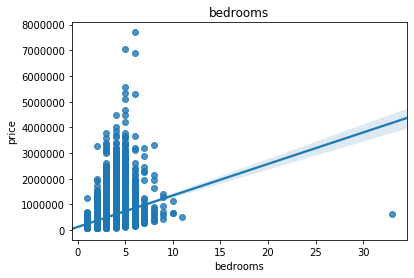

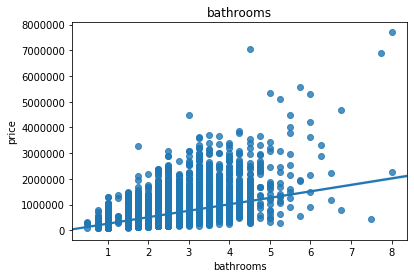

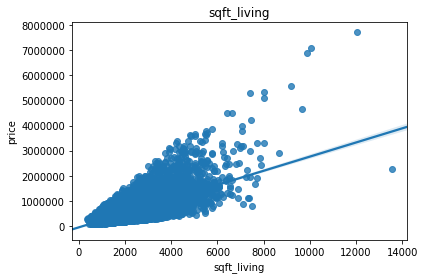

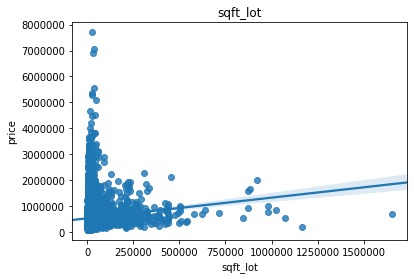

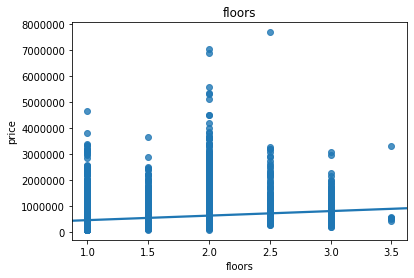

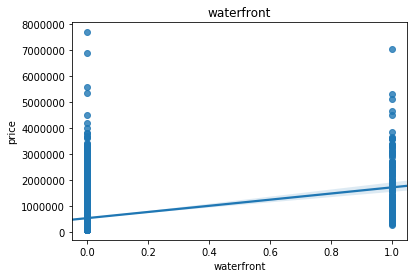

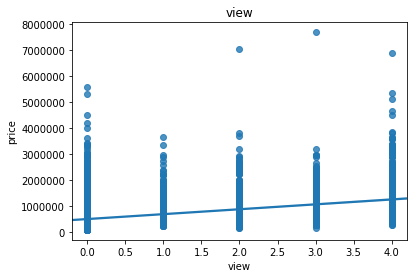

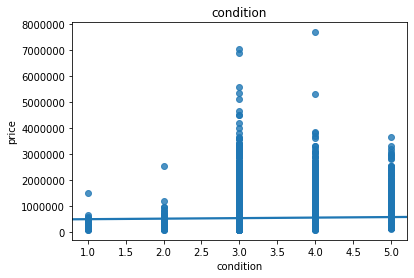

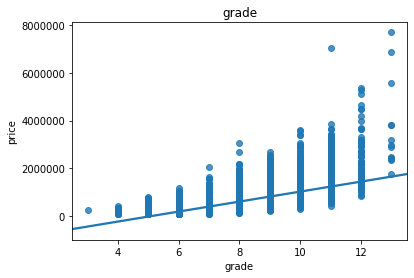

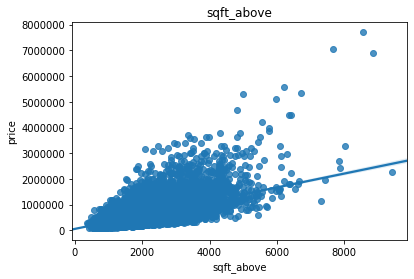

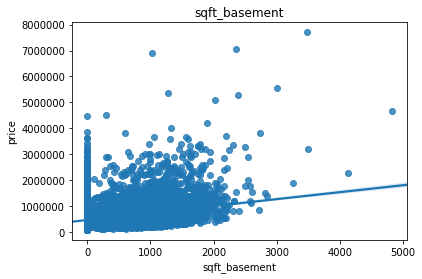

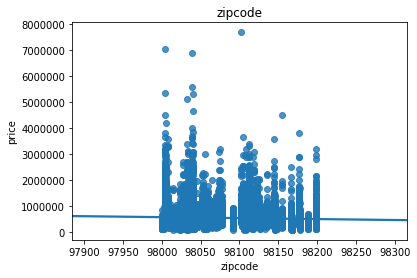

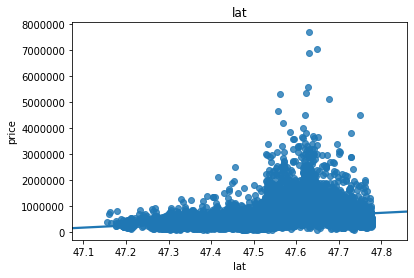

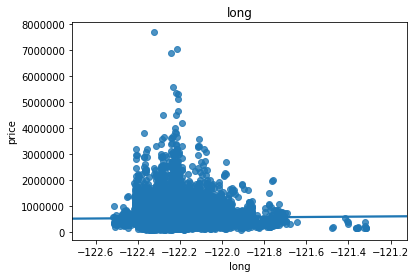

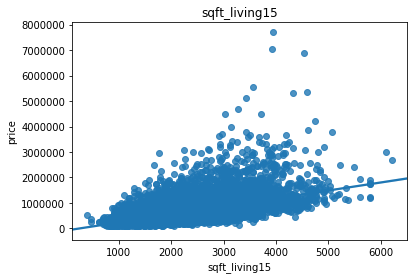

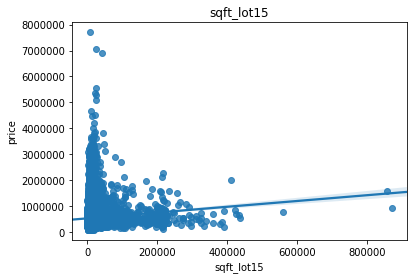

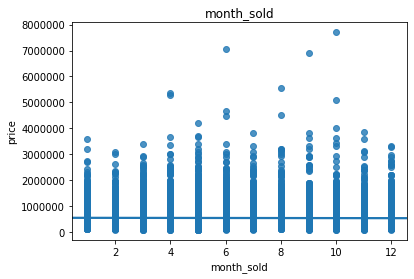

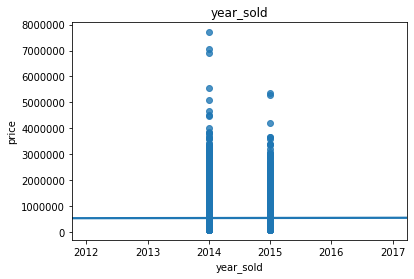

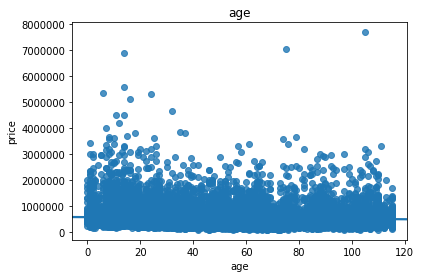

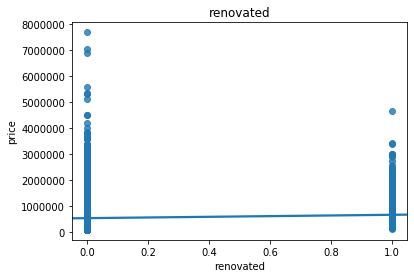

In [21]:
#Preview the relationship between features and target variables
X = df.drop(columns=['price'], axis=1)
for col in X.columns:
    plt.subplots(1, 1)
    sns.regplot(X[col], df.price)
    plt.title(col)

There are several features where there is a clear linear relationship with price, but there are some features where the relationship is not so clear. We can further look at the correlation between all of our features and price to get a better idea of which features have a linear relationship with the dependent variable. Prior to doing so, let's look at a map of these houses based on the latitude and longitude coordinates given to get an idea of how price varies by location.

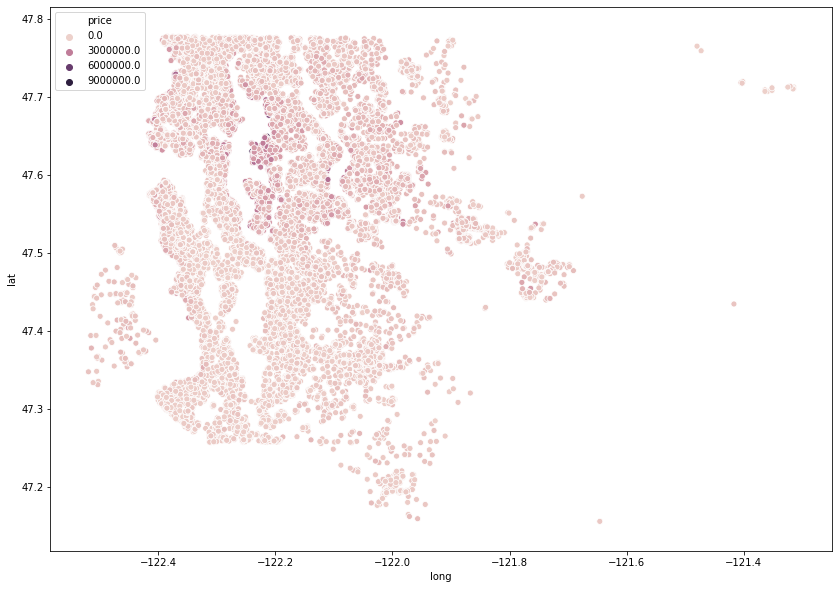

In [22]:
plt.figure(figsize=(14, 10))
sns.scatterplot(df['long'], df['lat'], hue=df['price']);

To no surprise, it seems that homes that are closer to downtown Seattle are higher priced, and prices tend to go down the further away from the city. Using the geopy library, we will create a column that calculates the distance in miles from Seattle and include this in our model.

In [23]:
from geopy import distance

lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
lat_long = list(map(eval, lat_long)) 

Seattle = (47.6062, -122.3321)
miles = []
for i in lat_long:
    miles.append(round(distance.distance(i, Seattle).miles, 1))
df['distance'] = miles

In [24]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold,age,renovated,distance
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,...,98178,47.5112,-122.257,1340,5650,10.0,2014.0,60,0,7.4
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,98125,47.7210,-122.319,1690,7639,12.0,2014.0,64,0,8.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,98028,47.7379,-122.233,2720,8062,2.0,2015.0,82,0,10.2
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,98136,47.5208,-122.393,1360,5000,12.0,2014.0,50,0,6.6
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,98074,47.6168,-122.045,1800,7503,2.0,2015.0,28,0,13.4


Now that we have our data cleaned, we will look at how each predictor correlates with price and we'll plot the correlations as well.

In [25]:
X = df.drop(columns=['price'], axis=1)
y = df.price

correlation_list = []
for col in X.columns:
    correlation_list.append(pearsonr(X[col], y)[0])
    
correlations = {}
for i, j in zip(X.columns, correlation_list):
    correlations[i] = round(j, 2)
sorted_correlations = pd.DataFrame(sorted(correlations.items(), key=lambda x: x[1], reverse=True), columns=['feature', 'correlations'])
sorted_correlations['feature'] = sorted_correlations['feature'].astype('string')
sorted_correlations

,feature,correlations
0,sqft_living,0.70
1,grade,0.67
2,sqft_above,0.61
3,sqft_living15,0.59
4,bathrooms,0.53
5,view,0.39
6,sqft_basement,0.32
7,bedrooms,0.31
8,lat,0.31
9,floors,0.26


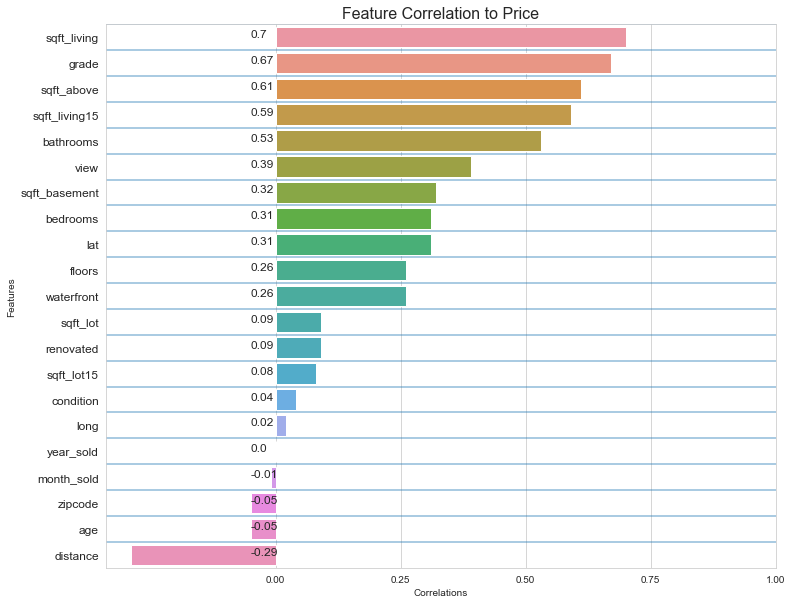

In [26]:
#Plot the feature correlation to price
plt.figure(figsize=(12, 10))
sns.set_style('whitegrid')
sns.barplot(sorted_correlations['correlations'], sorted_correlations['feature'])
plt.title('Feature Correlation to Price', fontsize=16)
plt.xlabel('Correlations')
plt.ylabel('Features')
plt.yticks(fontsize=12)
plt.xticks(np.linspace(0, 1, 5))
for ind, val in enumerate(sorted_correlations['correlations']):
    plt.text(x= -0.05, y= ind, s= val, fontsize=12)
    plt.axhline(ind - .5, alpha=0.5)
plt.show()

There are some features with almost no correlation to price, but rather than dropping these features right away, we can build a model and potentially engineer new features as we move along.

# Model 1: Using All Features

In [27]:
#Separate features and target columns
def linear_model(dataframe):
    #Create feature and target columns
    X = dataframe.drop(columns=['price'], axis=1)
    y = dataframe.price
    
    #Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
    #Fit the model
    linreg = LinearRegression()
    model = linreg.fit(X_train, y_train)
    model
    
    #View model accuracy
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print('Training Score:', round(train_score, 2))
    print('Test Score:', round(test_score, 2))
    print('Coefficients:', model.coef_)
    
    #View model summary in statsmodels
    X_train = sm.add_constant(X_train)
    smmodel = sm.OLS(y_train, X_train).fit()
    print(smmodel.summary())
    return smmodel

In [28]:
model = linear_model(df)
model

Training Score: 0.74
Test Score: 0.72
Coefficients: [-3.27318535e+04  3.49315615e+04  1.03013340e+02  1.93047149e-01
 -2.09754378e+04  7.00456309e+05  5.68015914e+04  2.86971199e+04
  8.44194111e+04  9.10882946e+01  3.24699770e+01 -7.44031278e+02
  2.11292491e+05  2.05131079e+05  1.52630272e+01 -5.34225450e-02
  1.26221073e+03  3.63450231e+04  2.03897424e+03  6.86594700e+04
 -1.85658382e+04]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     2296.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:32:41   Log-Likelihood:            -2.3436e+05
No. Observations:               17277   AIC:                         4.688e+05
Df Residuals:                   17255   BIC:        

Our first model has an adjusted r-squared of .736. There are a couple features with p_values that are insignificant, but before we drop these features from the data, let's check our residuals.

<Figure size 864x576 with 0 Axes>

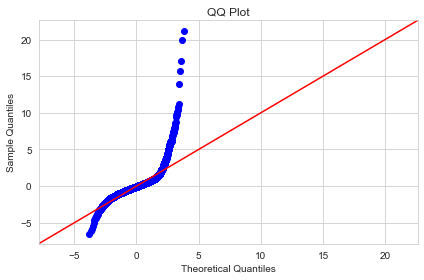

In [29]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout()
plt.savefig('Images/Model1')

Residuals are not normal, which violates are assumption of normality. Rather than using a log transformation, we will remove outliers.

# Model 2: Normalizing the Dependent Variable

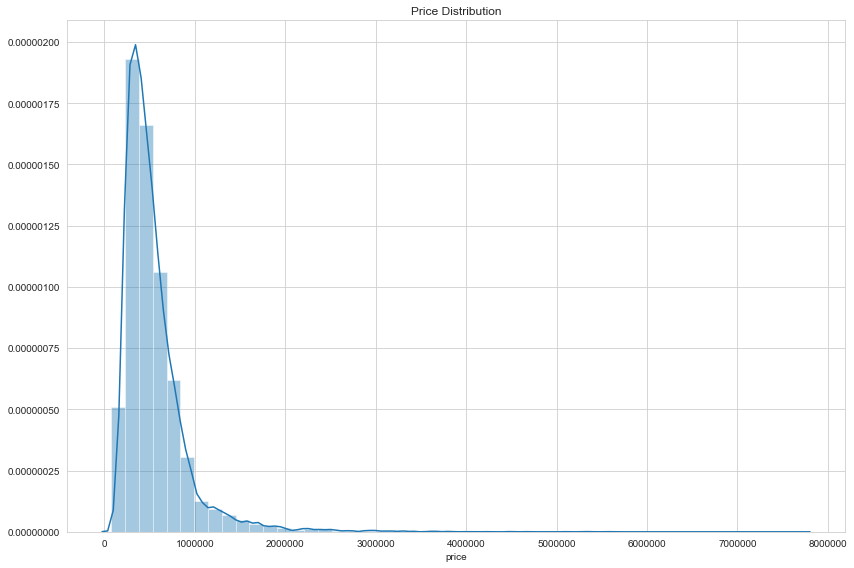

In [30]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution')
plt.tight_layout()
plt.savefig('Images/Model2a')

The distribution is positively skewed, so we will reduce our data further. This will limit our analysis to focusing more on middle class families with homes under 900k.

In [31]:
df = df[df['price'] <= 900000]

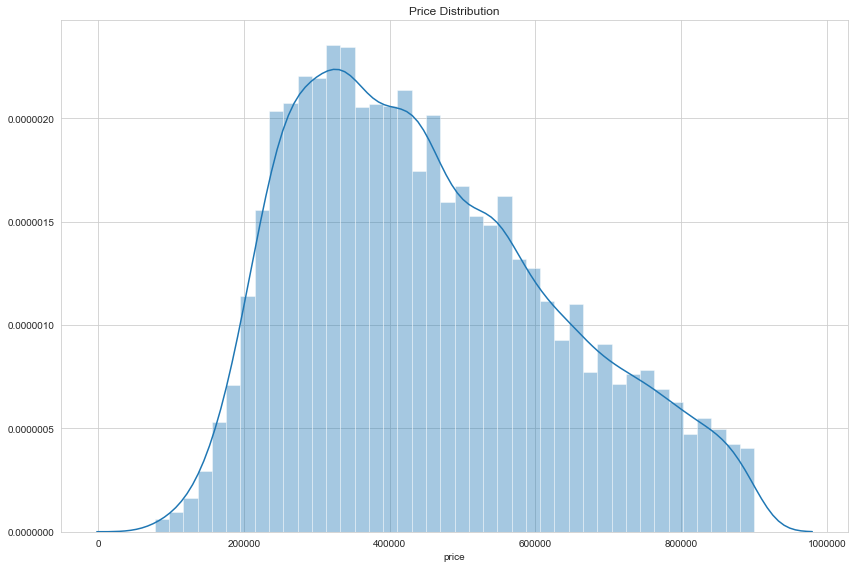

In [32]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution')
plt.tight_layout()
plt.savefig('Images/Model2b')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19564 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          19564 non-null  float64
 1   bedrooms       19564 non-null  int64  
 2   bathrooms      19564 non-null  float64
 3   sqft_living    19564 non-null  int64  
 4   sqft_lot       19564 non-null  int64  
 5   floors         19564 non-null  float64
 6   waterfront     19564 non-null  float64
 7   view           19564 non-null  float64
 8   condition      19564 non-null  int64  
 9   grade          19564 non-null  int64  
 10  sqft_above     19564 non-null  int64  
 11  sqft_basement  19564 non-null  float64
 12  zipcode        19564 non-null  int64  
 13  lat            19564 non-null  float64
 14  long           19564 non-null  float64
 15  sqft_living15  19564 non-null  int64  
 16  sqft_lot15     19564 non-null  int64  
 17  month_sold     19564 non-null  float64
 18  year_s

Although it is slightly skewed, the dependent variable is much closer to a normal distribution. Let's build a model with this transformation.

In [34]:
model = linear_model(df)
model

Training Score: 0.72
Test Score: 0.72
Coefficients: [-1.00103635e+04  1.84807829e+04  5.65868338e+01  2.85747959e-01
  1.50050594e+04  1.57281362e+05  2.64565148e+04  2.71774202e+04
  5.96977624e+04  2.07778840e+01  4.22303770e+00 -3.29516447e+02
  3.01393112e+05  2.14295083e+05  4.15497720e+01  1.33128571e-01
  3.31341901e+02  2.09936502e+04  1.31970148e+03  5.25401686e+04
 -1.09427669e+04]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1950.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:32:42   Log-Likelihood:            -2.0157e+05
No. Observations:               15651   AIC:                         4.032e+05
Df Residuals:                   15629   BIC:        

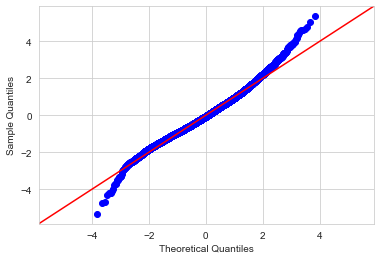

In [35]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.savefig('Images/Model2c')

Removing outliers and reducing our dependent variable brought down our adjusted r-squared to .723, but our residuals are much closer to a normal distribution. Several features still have insignifanct p-values greater than 0.05, but let's look at collinearity first prior to dropping these.

# Model 3: Dealing with Multicollinearity

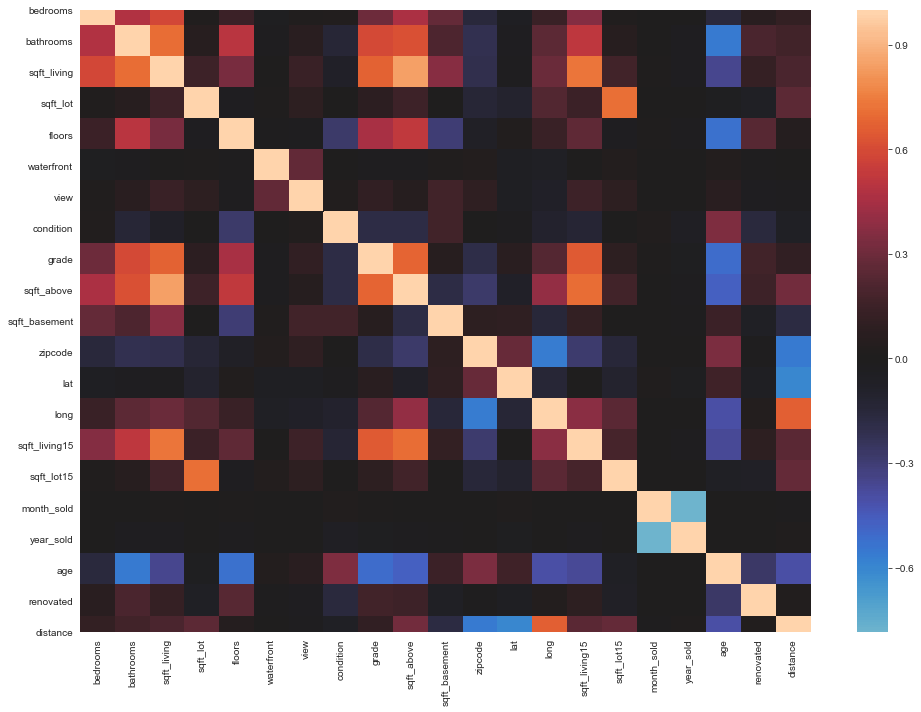

In [36]:
#View heatmap to get an idea of multicollinearity
X = df.drop(columns=['price'], axis=1)
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), center=0)
plt.tight_layout()
plt.savefig('Images/Model3a')
plt.show()

This gives a general idea of which predictors are correlated with each other. To filter even further, let's take a look at variables with a correlation above 0.7.

In [37]:
abs(X.corr()) >= .7

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold,age,renovated,distance
bedrooms,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False


There are several predictors with a correlation above 0.7. We can get an even clearer picture by returning highly correlated pairs with the stack method.

In [38]:
corr_df = X.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# set index to pairs
corr_df.set_index(['pairs'], inplace = True)

#drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
corr_df.columns = ['cc']

# drop duplicates
corr_df.drop_duplicates(inplace=True)

In [39]:
#Filter and correlations above .7 and below 1
corr_df[(corr_df.cc>.70) & (corr_df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.842717
"(year_sold, month_sold)",0.783542
"(sqft_living15, sqft_living)",0.722105
"(sqft_lot, sqft_lot15)",0.709571
"(bathrooms, sqft_living)",0.703255
"(sqft_living15, sqft_above)",0.702106


There are several features that seem to have multicollinearity. Rather than just dropping some of these features, let's first look at the variance inflation factor to understand the severity of the multicollinearity.

In [40]:
#Create dictionary of features and their variance inflation factor
X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_dict = dict(zip(X.columns, vif))
vif_dict

{'const': 55039143.4699468,
 'bedrooms': 1.6659401491582626,
 'bathrooms': 2.927860849384654,
 'sqft_living': 110.91920528217572,
 'sqft_lot': 2.0441468214665908,
 'floors': 2.160884659657865,
 'waterfront': 1.0875061338552472,
 'view': 1.194011567648947,
 'condition': 1.2126779960213212,
 'grade': 2.6469519596659272,
 'sqft_above': 97.98808175362224,
 'sqft_basement': 32.14719792231007,
 'zipcode': 1.7030284511244889,
 'lat': 1.9841963632979167,
 'long': 2.636494119782321,
 'sqft_living15': 2.6576464359532106,
 'sqft_lot15': 2.099295686664372,
 'month_sold': 2.595419748314412,
 'year_sold': 2.6058748350603462,
 'age': 2.5092101633405433,
 'renovated': 1.1174949963240295,
 'distance': 3.9077420619666903}

Several features have a variance inflation factor above 5, which tells us that the variance is over 500% bigger than what we would expect if there was no multicollinearity. Typically, a VIF over 5 signifies high correlation among features. Let's look at which features have a VIF over 5.

In [41]:
#Create a list of columns to drop with a vif cutoff of 5
new_dict = {}
for (key, value) in vif_dict.items():
    if value >= 5:
        new_dict[key] = value
columns_to_drop = list(new_dict.keys())
columns_to_drop = columns_to_drop[1:]
columns_to_drop

['sqft_living', 'sqft_above', 'sqft_basement']

Sqft_living, sqft_above, and sqft_basement are all over a VIF of 5. We will drop all sqft_above and sqft_basement to reduce multicollinearity.

In [42]:
#Drop sqft_above
df = df.drop(columns=['sqft_above', 'sqft_basement'], axis=1)

In [43]:
X = df.drop(columns=['price'], axis=1)
X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_dict = dict(zip(X.columns, vif))
vif_dict

{'const': 55025313.067928866,
 'bedrooms': 1.665449625424251,
 'bathrooms': 2.8398307946204393,
 'sqft_living': 4.1290138017112,
 'sqft_lot': 2.043686967560446,
 'floors': 1.6638489058144255,
 'waterfront': 1.0873630248218116,
 'view': 1.1767341702213245,
 'condition': 1.2062024813373302,
 'grade': 2.602336974818902,
 'zipcode': 1.7030182231737108,
 'lat': 1.9839015320489222,
 'long': 2.6226544893167243,
 'sqft_living15': 2.5762465352699575,
 'sqft_lot15': 2.09884530858717,
 'month_sold': 2.5951262499301038,
 'year_sold': 2.605737206897128,
 'age': 2.504837383536263,
 'renovated': 1.1172267023795908,
 'distance': 3.8203429204740753}

Looks like dropping our sqft_above and sqft_basement brought the VIF down for sqft_living under 5. Let's build another model with these columns dropped.

In [44]:
model = linear_model(df)
model

Training Score: 0.72
Test Score: 0.72
Coefficients: [-9.97663078e+03  1.64943234e+04  7.10638449e+01  2.86749746e-01
  2.12136204e+04  1.57849078e+05  2.54185341e+04  2.65790962e+04
  6.07102210e+04 -3.29241008e+02  3.01158520e+05  2.18093447e+05
  4.38060525e+01  1.36023897e-01  3.44256709e+02  2.10547105e+04
  1.32925573e+03  5.27380262e+04 -1.07293304e+04]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     2149.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:32:43   Log-Likelihood:            -2.0158e+05
No. Observations:               15651   AIC:                         4.032e+05
Df Residuals:                   15631   BIC:                         4.034e+05
Df Mod

Our adjusted R squared stays the same at .723, but month_sold is still showing as insignificant. We will remove this feature and rebuild our model.

# Model 4: Dropping Insignificant Features

In [45]:
#Drop sqft_lot15
df = df.drop(columns=['month_sold'], axis=1)

In [46]:
#Build new model
model = linear_model(df)
model

Training Score: 0.72
Test Score: 0.72
Coefficients: [-9.98327644e+03  1.64814699e+04  7.10808691e+01  2.86764531e-01
  2.12207948e+04  1.57731791e+05  2.54248972e+04  2.65537201e+04
  6.06938700e+04 -3.29461835e+02  3.01136099e+05  2.17956983e+05
  4.37971627e+01  1.36318745e-01  1.92477757e+04  1.32919155e+03
  5.27536105e+04 -1.07285035e+04]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     2268.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:32:43   Log-Likelihood:            -2.0159e+05
No. Observations:               15651   AIC:                         4.032e+05
Df Residuals:                   15632   BIC:                         4.034e+05
Df Model:             

Our adjusted R squared still stays the same at .711 and all features are significant. Next, we will further refine our data by removing additional, potential outliers.

# Model 5: Refining Features

An easy way to detect outliers and normalize our data is to create distribution plots of all columns.

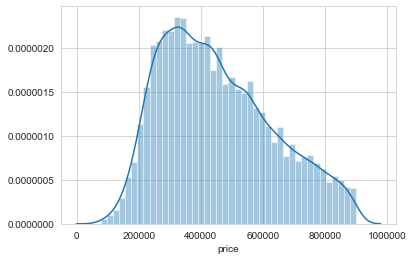

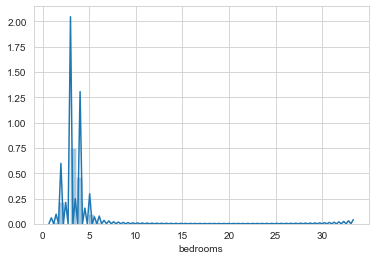

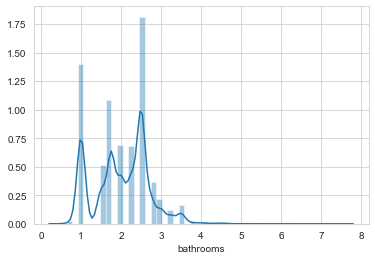

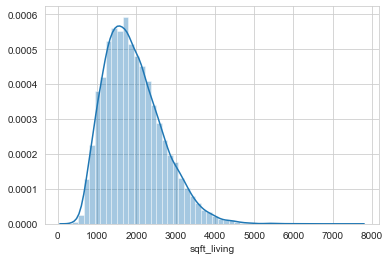

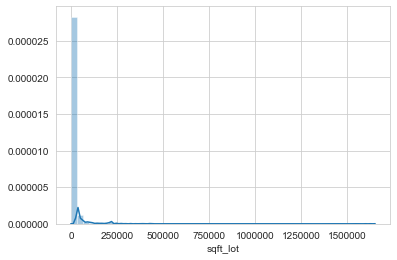

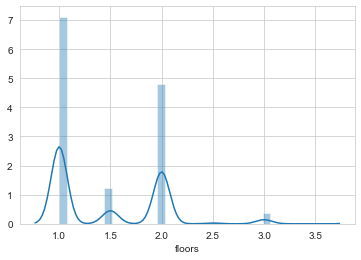

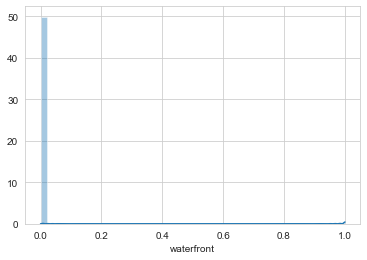

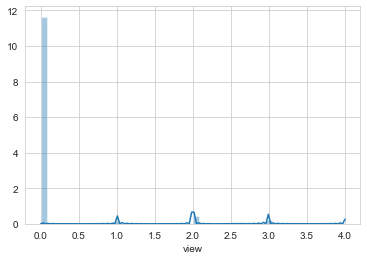

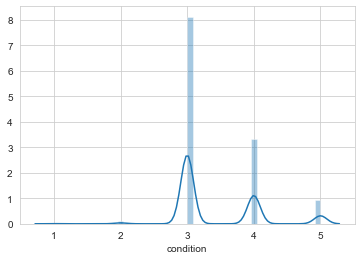

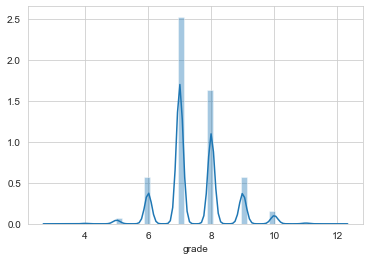

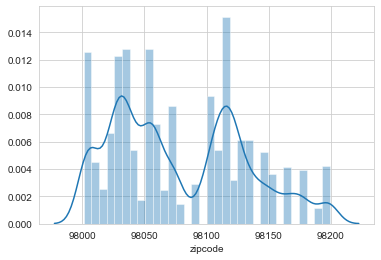

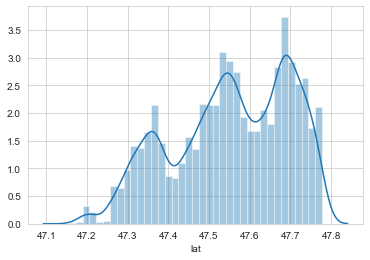

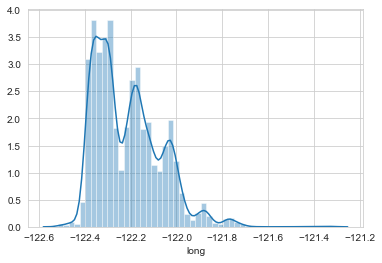

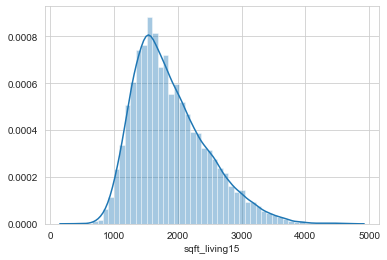

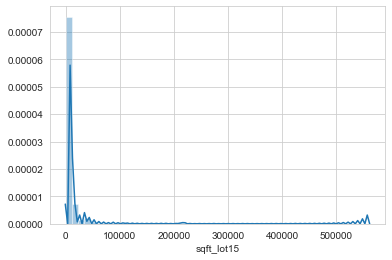

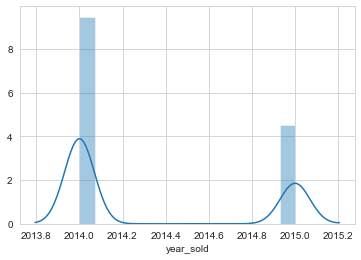

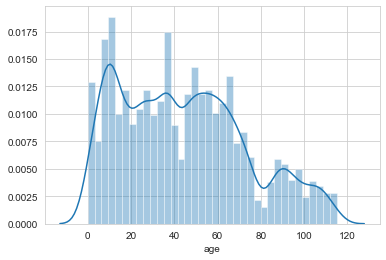

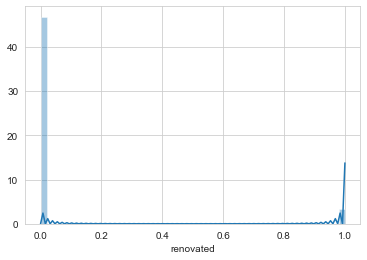

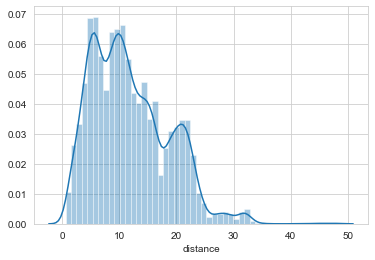

In [47]:
#View distribution plots for all columns
for col in df.columns:
    plt.subplots(1, 1)
    sns.distplot(df[col])

Several features have heavy tails, so we will reduce these features by removing outliers.

In [48]:
df[df['sqft_living'] > 6000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,age,renovated,distance
4020,800000.0,7,6.75,7480,41664,2.0,0.0,2.0,3,11,98166,47.4643,-122.368,2810,33190,2014.0,62,0,9.9
21034,900000.0,5,6.00,7120,40806,2.0,0.0,4.0,3,12,98006,47.5451,-122.114,3440,36859,2015.0,8,0,11.0


In [49]:
df[df['bedrooms'] > 11]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,age,renovated,distance
15856,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,98103,47.6878,-122.331,1330,4700,2014.0,68,0,5.6


Bedrooms and sqft_lot have extreme outliers. Sqft_living also has outliers, so we will remove them from each of these columns.

In [50]:
df = df[df['bedrooms'] <= 11]
df = df[df['sqft_lot'] <= 15000]
df = df[df['sqft_living'] <= 5000]

There are a few categorical features that may need to be converted to dummy variables. We can take a look at regression plots again to determine which features these are.

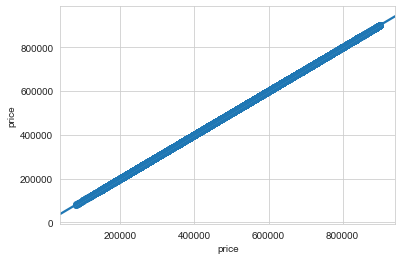

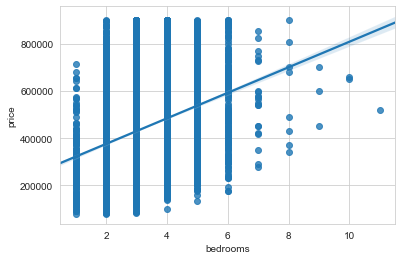

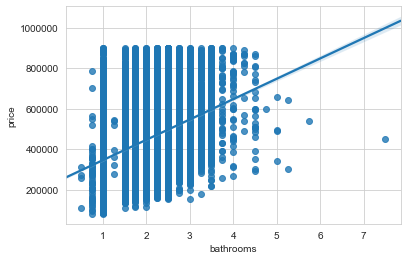

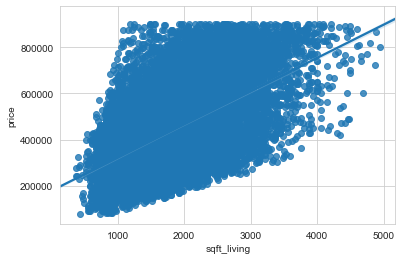

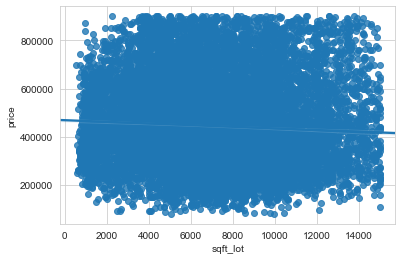

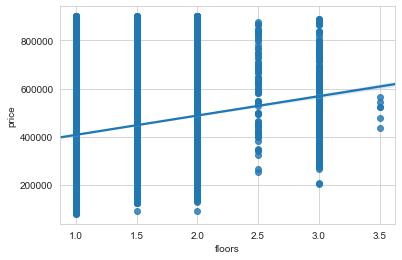

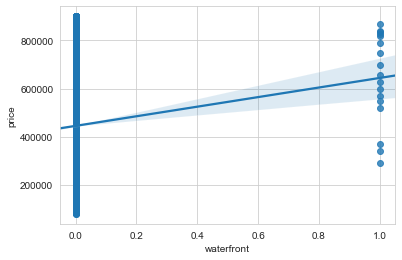

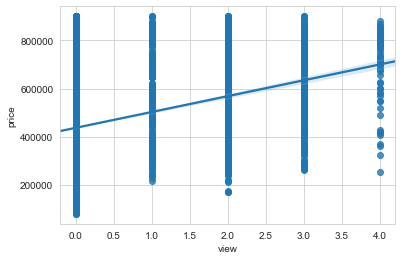

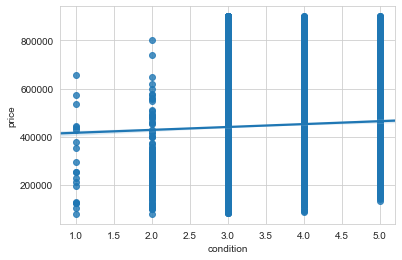

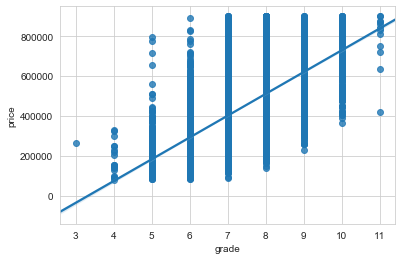

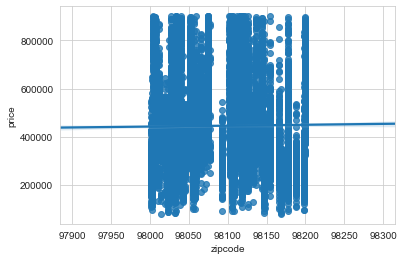

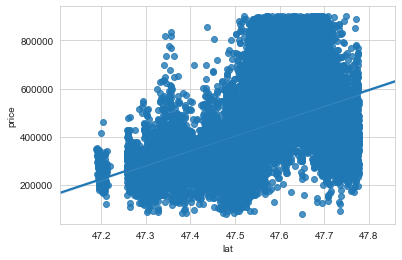

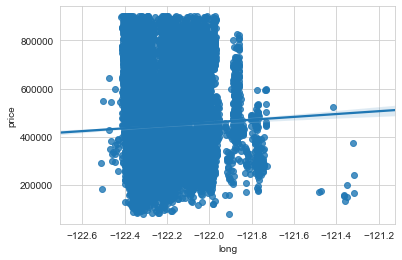

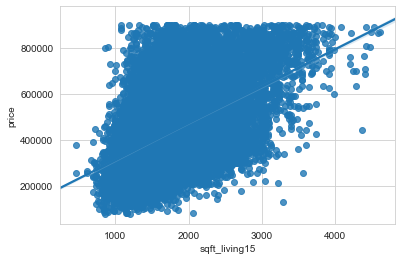

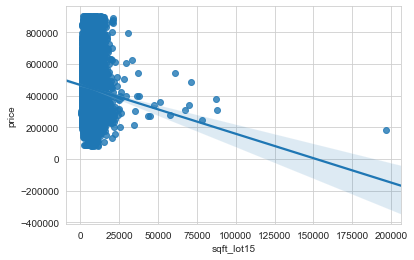

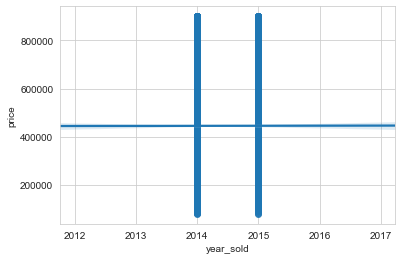

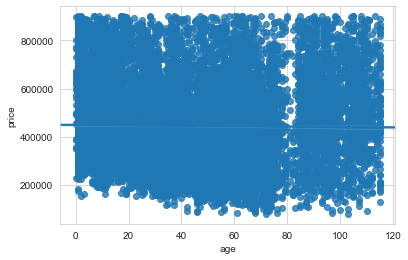

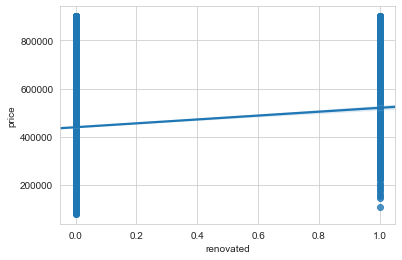

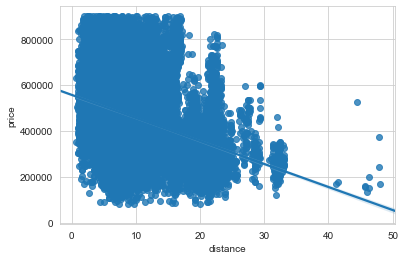

In [51]:
for col in df.columns:
    plt.subplots(1, 1)
    sns.regplot(df[col], df.price)

In [52]:
df.zipcode.nunique()

70

Too many categories in zipcode, and since we already created a distance from downtown column as our geographical feature, we can remove zipcode.

In [53]:
df = df.drop(columns=['zipcode'], axis=1)

Floors, condition, and view don't seem to increase the price as values increase. We can potentially create dummy variables with these features, but prior to doing so we will look at boxplots to get a better idea if this is the right action to take.

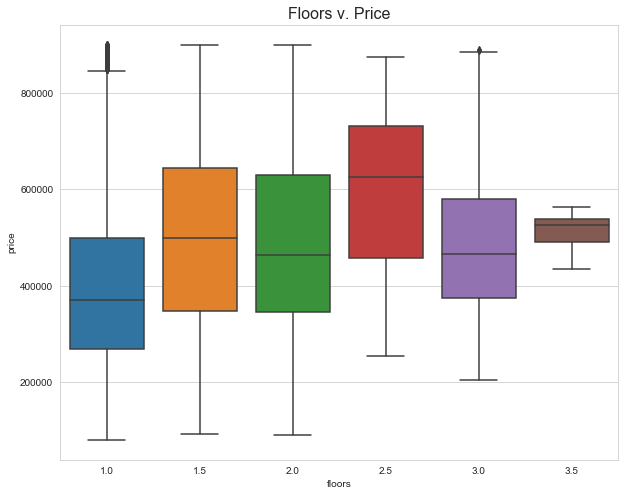

In [54]:
plt.figure(figsize=(10, 8))
plt.title('Floors v. Price', fontsize=16)
sns.boxplot(df.floors, df.price);

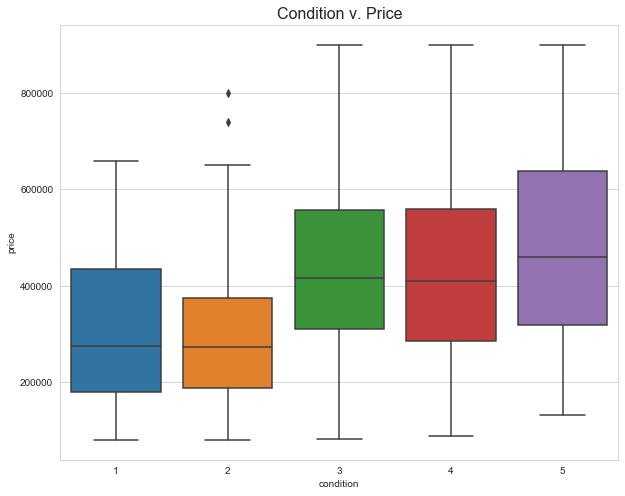

In [55]:
plt.figure(figsize=(10, 8))
plt.title('Condition v. Price', fontsize=16)
sns.boxplot(df.condition, df.price);

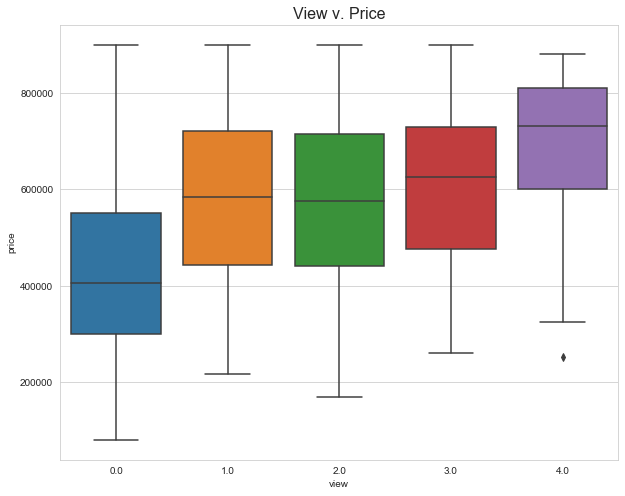

In [56]:
plt.figure(figsize=(10, 8))
plt.title('View v. Price', fontsize=16)
sns.boxplot(df.view, df.price);

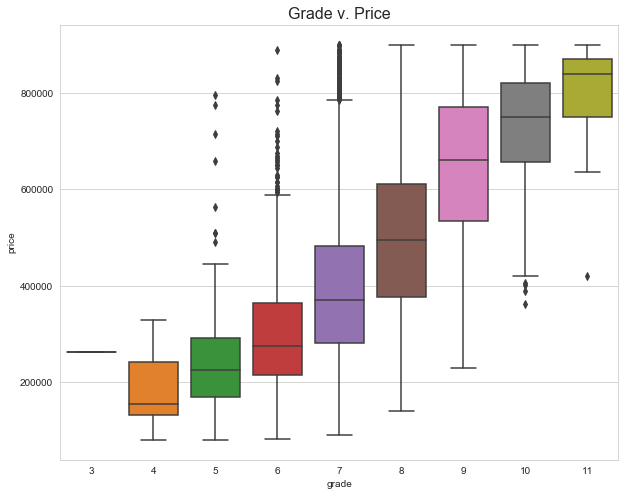

In [57]:
plt.figure(figsize=(10, 8))
plt.title('Grade v. Price', fontsize=16)
sns.boxplot(df.grade, df.price);

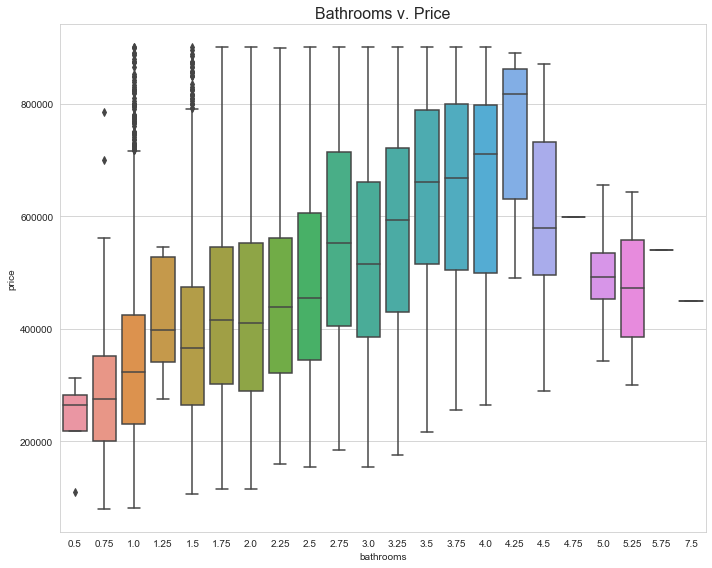

In [58]:
plt.figure(figsize=(10, 8))
plt.title('Bathrooms v. Price', fontsize=16)
sns.boxplot(df.bathrooms, df.price)
plt.tight_layout()
plt.savefig('Images/Model5')
plt.show()

In [59]:
df = df[df['bathrooms'] < 5.0]

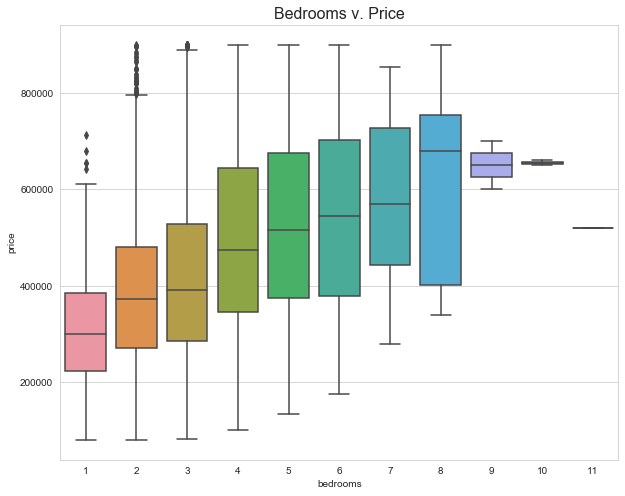

In [60]:
plt.figure(figsize=(10, 8))
plt.title('Bedrooms v. Price', fontsize=16)
sns.boxplot(df.bedrooms, df.price);

In [61]:
df = df[df['bedrooms'] < 11]

In [62]:
model = linear_model(df)
model

Training Score: 0.72
Test Score: 0.72
Coefficients: [-7.80853583e+03  1.57756362e+04  7.33452129e+01 -2.38035301e+00
  9.39103571e+03  2.44521809e+05  2.29748684e+04  2.76741781e+04
  6.37555976e+04  3.17462796e+05  2.68029294e+05  5.37360465e+01
 -1.02733027e+00  1.81201616e+04  1.37637048e+03  4.33207759e+04
 -9.35381117e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     2071.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:33:11   Log-Likelihood:            -1.7469e+05
No. Observations:               13572   AIC:                         3.494e+05
Df Residuals:                   13554   BIC:                         3.496e+05
Df Model:                          17 

Our adjusted r-squared is .719, but we also need to check if there any interactions between independent variables.

# Model 6: Dealing with Interactions

In [63]:
linreg = LinearRegression()

#Split features and target
X = df.drop(columns=['price'], axis=1)
y = df.price

#Utilize cross validation to determine baseline score
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(linreg, X, y, scoring='r2', cv=crossvalidation))

from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(linreg, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 5 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:10])

0
50
100
Top 5 interactions: [('lat', 'distance', 0.749), ('grade', 'distance', 0.729), ('sqft_living', 'distance', 0.726), ('sqft_living15', 'distance', 0.726), ('sqft_living', 'lat', 0.725), ('grade', 'lat', 0.725), ('lat', 'sqft_lot15', 0.724), ('sqft_lot', 'lat', 0.723), ('lat', 'sqft_living15', 0.723), ('bedrooms', 'distance', 0.722)]


Latitude and distance seem to have the highest r-squared. We will include this as an interaction term in our model.

In [64]:
df['lat_distance'] = df['lat'] * df['distance']
df['sqft_living15_distance'] = df['sqft_living15'] * df['distance']

In [65]:
X = df.drop(columns=['price'], axis=1)
X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_dict = dict(zip(X.columns, vif))
vif_dict

{'const': 21466457.84948566,
 'bedrooms': 1.8098939838100758,
 'bathrooms': 2.901185063632412,
 'sqft_living': 4.304433003486623,
 'sqft_lot': 2.790478072852826,
 'floors': 2.0660537234420318,
 'waterfront': 1.060744207293307,
 'view': 1.1427684187529723,
 'condition': 1.222729755798939,
 'grade': 2.5401734668347786,
 'lat': 9.164824097850659,
 'long': 2.71802891436659,
 'sqft_living15': 7.431455980693994,
 'sqft_lot15': 2.155425857910317,
 'year_sold': 1.0076959815633189,
 'age': 2.7204039347338926,
 'renovated': 1.1499432963365301,
 'distance': 202724.9694443268,
 'lat_distance': 202013.19675456194,
 'sqft_living15_distance': 22.75670710044289}

Multicollinearity is expected between our newly created interaction variable and its features and does not need to be eliminated in this case. Let's look at our feature correlation to price again.

In [66]:
X = df.drop(columns=['price'], axis=1)
y = df.price

correlation_list = []
for col in X.columns:
    correlation_list.append(pearsonr(X[col], y)[0])
    
correlations = {}
for i, j in zip(X.columns, correlation_list):
    correlations[i] = round(j, 2)
sorted_correlations = pd.DataFrame(sorted(correlations.items(), key=lambda x: x[1], reverse=True), columns=['feature', 'correlations'])
sorted_correlations['feature'] = sorted_correlations['feature'].astype('string')
sorted_correlations

,feature,correlations
0,grade,0.56
1,sqft_living,0.55
2,sqft_living15,0.50
3,lat,0.48
4,bathrooms,0.39
5,bedrooms,0.27
6,floors,0.24
7,view,0.20
8,renovated,0.12
9,waterfront,0.04


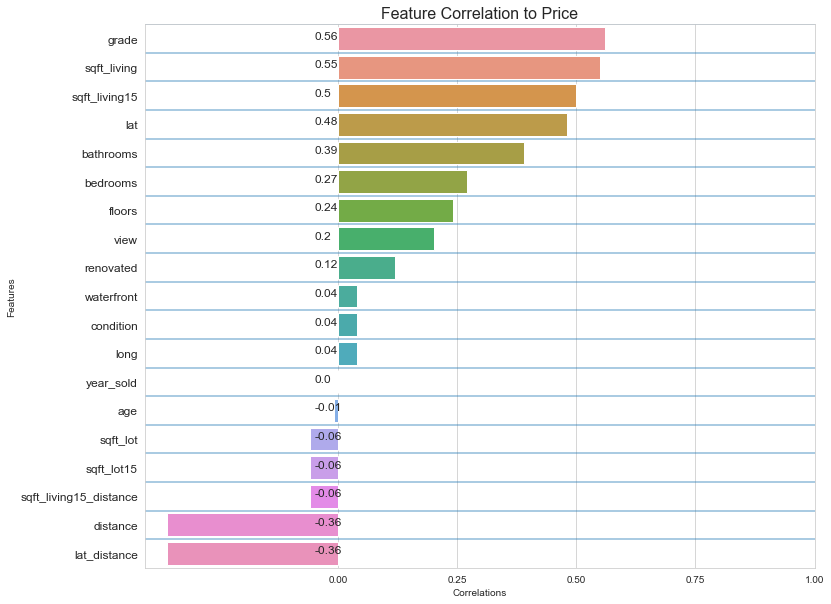

In [67]:
#Plot the feature correlation to price
plt.figure(figsize=(12, 10))
sns.set_style('whitegrid')
sns.barplot(sorted_correlations['correlations'], sorted_correlations['feature'])
plt.title('Feature Correlation to Price', fontsize=16)
plt.xlabel('Correlations')
plt.ylabel('Features')
plt.yticks(fontsize=12)
plt.xticks(np.linspace(0, 1, 5))
for ind, val in enumerate(sorted_correlations['correlations']):
    plt.text(x= -0.05, y= ind, s= val, fontsize=12)
    plt.axhline(ind - .5, alpha=0.5)
plt.show()

In [68]:
model = linear_model(df)
model

Training Score: 0.76
Test Score: 0.75
Coefficients: [-9.65361965e+03  1.05499370e+04  8.40002610e+01 -8.28537667e-01
  6.24799188e+03  2.73490537e+05  2.09313494e+04  2.26422536e+04
  5.72666661e+04  8.84259704e+05  4.11973348e+05  1.04863330e+02
 -4.86030099e-01  1.94448066e+04  9.96366290e+02  4.37197392e+04
  2.07371100e+06 -4.37790245e+04 -4.08207014e+00]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     2225.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:33:18   Log-Likelihood:            -1.7377e+05
No. Observations:               13572   AIC:                         3.476e+05
Df Residuals:                   13552   BIC:                         3.477e+05
Df Mod

One potential issue is that bedrooms has a negative coefficient when there is a positive correlation. To make our model interpretable, we will remove this feature. Additionally, sqft_lot15 is insignificant, so we will remove this as well.

In [69]:
#Drop bedrooms, sqft_lot and long
df = df.drop(columns=['bedrooms', 'sqft_lot15'])

In [70]:
X = df.drop(columns=['price'], axis=1)
y = df.price

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)

#Fit the model
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
model

#View model accuracy
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print('Training Score:', round(train_score, 2))
print('Test Score:', round(test_score, 2))
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

#View model summary in statsmodels
X_train = sm.add_constant(X_train)
smmodel = sm.OLS(y_train, X_train).fit()
smmodel.summary()

Training Score: 0.76
Test Score: 0.75
Intercept: -30837394.480328865
Coefficients: [ 7.88096920e+03  7.61736928e+01 -1.52681933e+00  6.47025947e+03
  2.71639292e+05  2.18624347e+04  2.23169205e+04  5.83821200e+04
  8.87319139e+05  4.12434249e+05  1.04472210e+02  1.92343795e+04
  9.79425260e+02  4.33517021e+04  2.07435479e+06 -4.37968614e+04
 -3.95484020e+00]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2470.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:33:18   Log-Likelihood:            -1.7381e+05
No. Observations:               13572   AIC:                         3.477e+05
Df Residuals:                   13554   BIC:                         3.478e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -3.084e+07   3.52e+06     -8.765      0.000   -3.77e+07   -2.39e+07
bathrooms               7880.9692   1856.793      4.244      0.000    4241.397    1.15e+04
sqft_living               76.1737      2.090     36.445      0.000      72.077      80.271
sqft_lot                  -1.5268      0.335     -4.561      0.000      -2.183      -0.871
floors                  6470.2595   2002.365      3.231      0.001    2545.346    1.04e+04
waterfront              2.716e+05   2.51e+04     10.805      0.000    2.22e+05    3.21e+05
view                    2.186e+04   1483.681     14.735      0.000     1.9e+04    2.48e+04
condition               2.232e+04   1292.207     17.270      0.000    1.98e+04    2.48e+04
grade                   5.838e+04   1307.713     44.644      0.000    5.58e+04    6.09e+04
lat                     8.873e+05   1.63e+04     54.305      0.000    8.55e+05    9.19e+05
long                    4.124e+05   9298.814     44.353      0.000    3.94e+05    4.31e+05
sqft_living15            104.4722      3.730     28.009      0.000      97.161     111.783
year_sold               1.923e+04   1627.116     11.821      0.000     1.6e+04    2.24e+04
age                      979.4253     41.949     23.348      0.000     897.200    1061.650
renovated               4.335e+04   3161.858     13.711      0.000    3.72e+04    4.95e+04
distance                2.074e+06   5.25e+04     39.544      0.000    1.97e+06    2.18e+06
lat_distance            -4.38e+04   1106.953    -39.565      0.000    -4.6e+04   -4.16e+04
sqft_living15_distance    -3.9548      0.240    -16.510      0.000      -4.424      -3.485
==============================================================================
Omnibus:                      437.814   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              738.084
Skew:                           0.286   Prob(JB):                    5.34e-161
Kurtosis:                       3.989   Cond. No.                     1.25e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

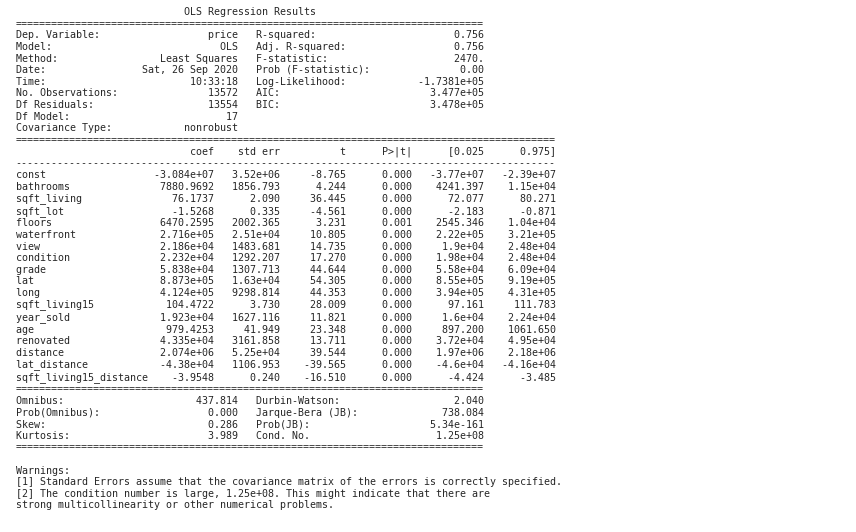

In [71]:
#Save model summary as image
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(smmodel.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('Images/FinalModel.png')

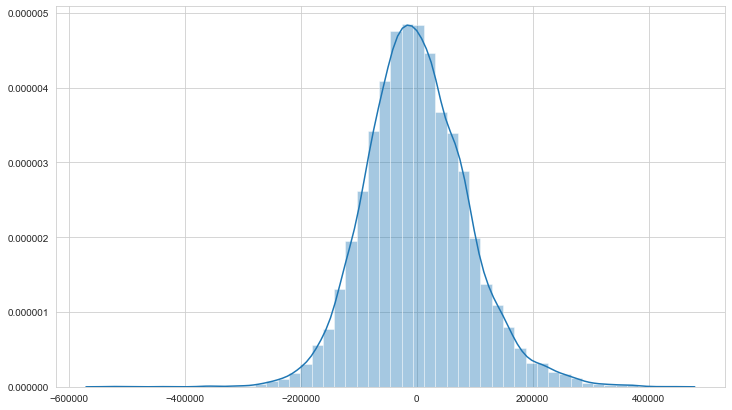

In [72]:
sns.distplot(smmodel.resid)

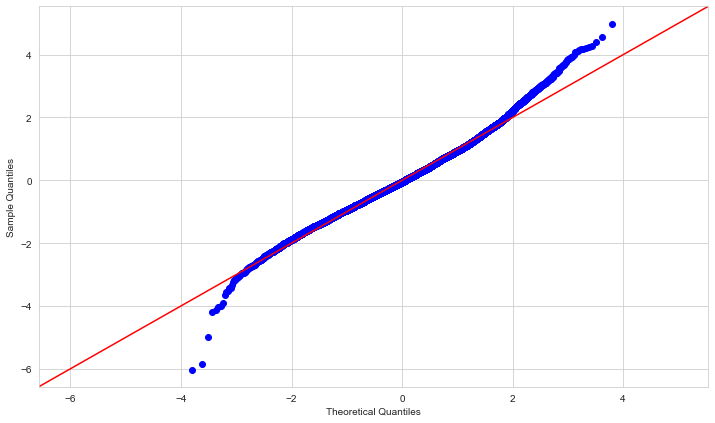

In [73]:
fig = sm.graphics.qqplot(smmodel.resid, dist=stats.norm, line='45', fit=True)

Residuals resemble a normal distribution. Our kurtosis is a little high but still at an acceptable level in order to keep our model interpretable.

In [74]:
model_coefficients = pd.DataFrame(smmodel.params[1:], columns=['coefficients'])

In [75]:
model_coefficients.sort_values(by='coefficients', ascending=False)

,coefficients
distance,2.074355e+06
lat,8.873191e+05
long,4.124342e+05
waterfront,2.716393e+05
grade,5.838212e+04
renovated,4.335170e+04
condition,2.231692e+04
view,2.186243e+04
year_sold,1.923438e+04
bathrooms,7.880969e+03


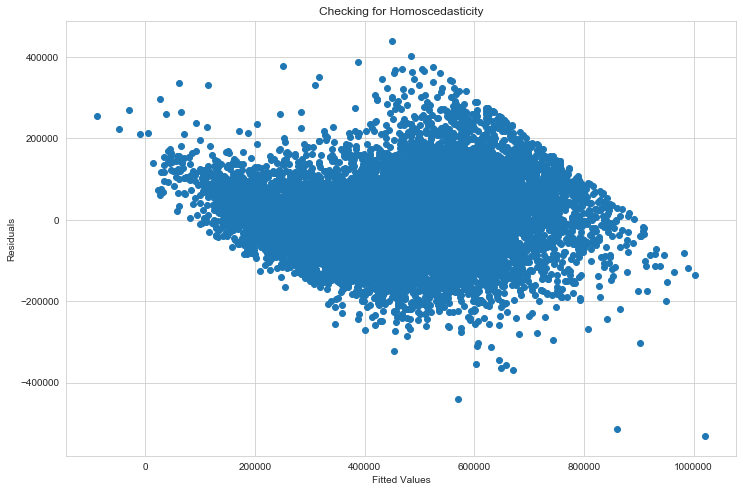

In [76]:
plt.figure(figsize=(12, 8))
plt.scatter(train_preds, smmodel.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity')
plt.show()

In [77]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(smmodel.resid, smmodel.model.exog)
list(zip(name, test))

[('F statistic', 0.980795212903344), ('p-value', 0.7874535324333823)]

With an insignificant p-value, we cannot reject the null hypothesis and our residuals are homoscedastic.

# Testing the Final Model

In [78]:
print("Final Regression Formula\n")
print(model.intercept_, '+')
print('sum(')
for i in range(len(model_coefficients)):
    print(model_coefficients.coefficients[i], '*', model_coefficients.index[i])
print(')')

Final Regression Formula

-30837394.480328865 +
sum(
7880.969201693022 * bathrooms
76.17369284118595 * sqft_living
-1.5268193253042313 * sqft_lot
6470.2594727958585 * floors
271639.29181160673 * waterfront
21862.4346662303 * view
22316.920485692543 * condition
58382.120041817594 * grade
887319.1394322908 * lat
412434.24878303445 * long
104.47221048824318 * sqft_living15
19234.379456420887 * year_sold
979.425259838251 * age
43351.70208090622 * renovated
2074354.7873602198 * distance
-43796.86139833923 * lat_distance
-3.9548401970239637 * sqft_living15_distance
)


In [79]:
def calculate_price():
    '''Calculate predicted sale price of homes using previously built regression model.
    
    Parameters: Input by User'''
    
    bathrooms = input("How many bathrooms does the property have? (1 to 4.75) ")
    sqft_living = input("What is the square footage? (370 to 4940) ")
    sqft_lot = input("What is the square footage of the lot? (520 to 20000) ")
    floors = input("How many floors does the property have? (1 to 3.5) ")
    waterfront = input("Is the property a waterfront property? 1=yes, 0=no ")
    view = input("How many views has the property had? (0 to 4) ")
    condition = input("What is the condition of the property? (1 to 5) ")
    grade = input("What is the property grade? (3 to 11) ")
    lat = input("What is the latitude of the property? (47.1559 to 47.7776) ")
    long = input("What is the longitude of the property? (-122.512 to -121.315) ")
    sqft_living15 = input("What is the square footage of interior housing living space of nearest 15 neighbors? (460 to 4950) ")
    year_sold = input("Which year was the property sold, 2014 or 2015? ")
    age = input("How old is the property? (0 to 115 years) ")
    renovated = input("Has the property been renovated in the last 10 years or built within the last 5? 1=yes, 0=no ")
    distance = input("What is the distance from downtown Seattle? (0.1 to 39.5 miles) ")
    lat_distance = float(lat) * float(distance)
    sqft_living15_distance = float(sqft_living15) * float(distance)
    
    features = np.array([bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, 
                         lat, long, sqft_living15, year_sold, age, renovated, distance, lat_distance, 
                         sqft_living15_distance], dtype=float)
    formula = model.intercept_ + (np.dot(model.coef_, features))
    
    print("\nThe predicted sale price of this home is: ")
    return formula

In [80]:
df.head()

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,lat,long,sqft_living15,year_sold,age,renovated,distance,lat_distance,sqft_living15_distance
0,221900.0,1.00,1180,5650,1.0,0.0,0.0,3,7,47.5112,-122.257,1340,2014.0,60,0,7.4,351.58288,9916.0
1,538000.0,2.25,2570,7242,2.0,0.0,0.0,3,7,47.7210,-122.319,1690,2014.0,64,0,8.0,381.76800,13520.0
2,180000.0,1.00,770,10000,1.0,0.0,0.0,3,6,47.7379,-122.233,2720,2015.0,82,0,10.2,486.92658,27744.0
3,604000.0,3.00,1960,5000,1.0,0.0,0.0,5,7,47.5208,-122.393,1360,2014.0,50,0,6.6,313.63728,8976.0
4,510000.0,2.00,1680,8080,1.0,0.0,0.0,3,8,47.6168,-122.045,1800,2015.0,28,0,13.4,638.06512,24120.0


In [90]:
calculate_price()

How many bathrooms does the property have? (1 to 4.75) 2.25
What is the square footage? (370 to 4940) 2570
What is the square footage of the lot? (520 to 20000) 7242
How many floors does the property have? (1 to 3.5) 2
Is the property a waterfront property? 1=yes, 0=no 0
How many views has the property had? (0 to 4) 0
What is the condition of the property? (1 to 5) 3
What is the property grade? (3 to 11) 7
What is the latitude of the property? (47.1559 to 47.7776) 47.7210
What is the longitude of the property? (-122.512 to -121.315) -122.319
What is the square footage of interior housing living space of nearest 15 neighbors? (460 to 4950) 1690
Which year was the property sold, 2014 or 2015? 2014
How old is the property? (0 to 115 years) 64
Has the property been renovated in the last 10 years or built within the last 5? 1=yes, 0=no 0
What is the distance from downtown Seattle? (0.1 to 39.5 miles) 8

The predicted sale price of this home is: 


547234.9167589843

# Conclusion

Multiple regression analysis was used to test if certain variables significantly predicted the 
sale price of homes in King County, Washington. The results of the regression indicated that 
15 predictors and 2 interaction terms explained 75.6% of the variance (R2= 0.756, F=2470, p< 0.01). All of the independent variables used in the model were significant predictors of sale price with p-values less than 0.05. For further analysis, other models can be used to improve accuracy of results, such as a Random Forest Regression model. Additionally, one could build a second regression model to predict prices of homes over 900k. A few practical questions/recommendations are provided as part of understanding the data further.

# Practical Questions/Recommendations

### Question 1: How do renovations impact sale price?

renovated
0    410988.0
1    494997.5
Name: price, dtype: float64


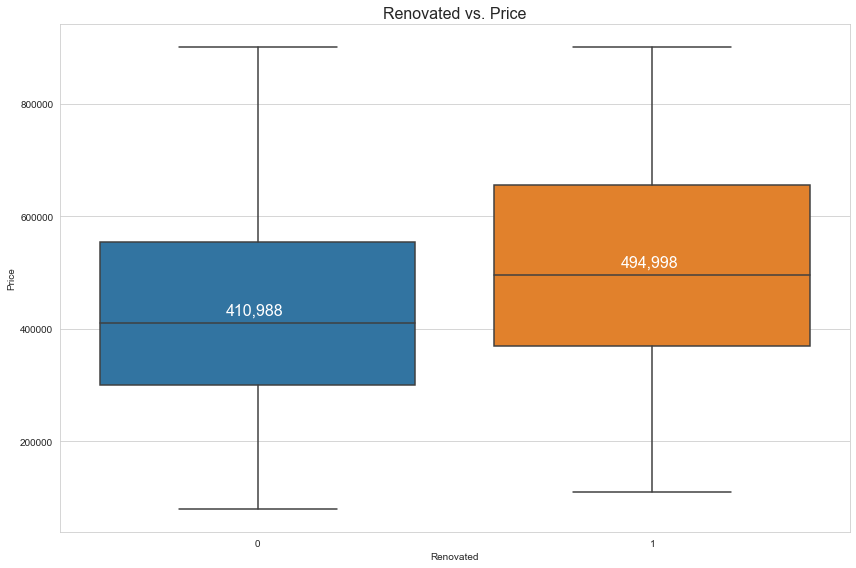

In [82]:
#Print the median sale price of renovated and unrenovated homes
print(df.groupby(['renovated'])['price'].median())

#Plot renovated vs. price
plt.figure(figsize=(12, 8))
sns.boxplot(df.renovated, df.price)
plt.title('Renovated vs. Price', fontsize=16)
plt.xlabel('Renovated')
plt.ylabel('Price')
plt.text(x=-0.08, y=425000, s='410,988', c='white', fontsize=16)
plt.text(x=0.92, y=510000, s='494,998', c='white', fontsize=16)
plt.tight_layout()
plt.savefig('Images/Question1.png')
plt.show()

Looking at homes under 900k that have been renovated or built within 10 years prior to selling, the median difference between recently renovated/newly built and unrenovated homes is $84,010, so renovations of some sort do impact the sale price significantly, showing over a 20 percent increase. Obiously, different types of renovations can lead to different results, but a good rule of thumb based on this data is that, when renovating, spend no more than 15 percent of the value of your home to help protect you from losing money.

### Question 2: How do prices compare when considering distance from downtown and square footage?

In [83]:
#Create price per sqft column
df['price_sqft'] = df.price / df.sqft_living

In [84]:
#Create bins of sqft within 5 miles of downtown
sqft_under1k_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] < 1000)]
sqft_1to2k_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] >= 1000) & (df['sqft_living'] < 2000)]
sqft_2to3k_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] >= 2000) & (df['sqft_living'] < 3000)]
sqft_3kplus_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] >= 3000)]

In [85]:
#Create bins of sqft further than 5 miles of downtown
sqft_under1k = df.loc[(df['distance'] > 5) & (df['sqft_living'] < 1000)]
sqft_1to2k = df.loc[(df['distance'] > 5) & (df['sqft_living'] >= 1000) & (df['sqft_living'] < 2000)]
sqft_2to3k = df.loc[(df['distance'] > 5) & (df['sqft_living'] >= 2000) & (df['sqft_living'] < 3000)]
sqft_3kplus = df.loc[(df['distance'] > 5) & (df['sqft_living'] >= 3000)]

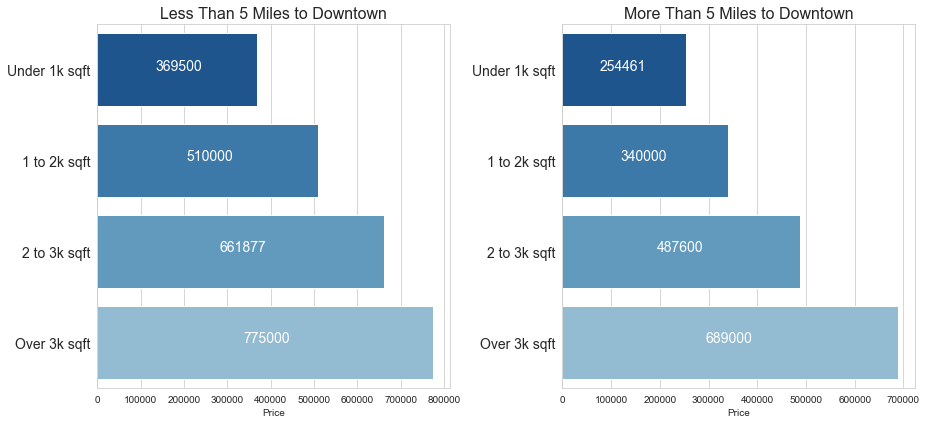

In [86]:
#Create list of sqft bins and median prices
names = ["Under 1k sqft", "1 to 2k sqft", "2 to 3k sqft", "Over 3k sqft"]
medians_5 = [sqft_under1k_5.price.median(), sqft_1to2k_5.price.median(), sqft_2to3k_5.price.median(), 
           sqft_3kplus_5.price.median()]

#Plot median price vs. square footage
sns.set_palette('Blues_r')
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
sns.barplot(medians_5, names)
for i in range(len(medians_5)):
    plt.text(x= (medians_5[i]/2) - 50000, y=i, s=int(medians_5[i]), c='white', fontsize=14)
plt.title('Less Than 5 Miles to Downtown', fontsize=16)
plt.xlabel('Price')
plt.yticks(fontsize=14)

#List of sqft bins further than 5 miles from downtown
medians = [sqft_under1k.price.median(), sqft_1to2k.price.median(), sqft_2to3k.price.median(), 
           sqft_3kplus.price.median()]

#Plot median price vs. square footage
plt.subplot(1, 2, 2)
for i in range(len(medians)):
    plt.text(x= (medians[i]/2) - 50000, y=i, s=int(medians[i]), c='white', fontsize=14)
sns.barplot(medians, names)
plt.title('More Than 5 Miles to Downtown', fontsize=16)
plt.xlabel('Price')
plt.yticks(fontsize=14)
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.savefig('Images/Question2a.png')
plt.show()

The median home price for homes within 5 miles of downtown compared to homes further than 5 miles to downtown:

- Under 1k sqft: 115k higher

- Between 1 to 2k sqft: 170k higher

- Between 2 to 3k sqft: 174k higher

- Over 3k sqft: 86k higher 

Naturally, downtown homes are significantly higher in every category of square footage, so location is a huge factor to consider when buying a home.

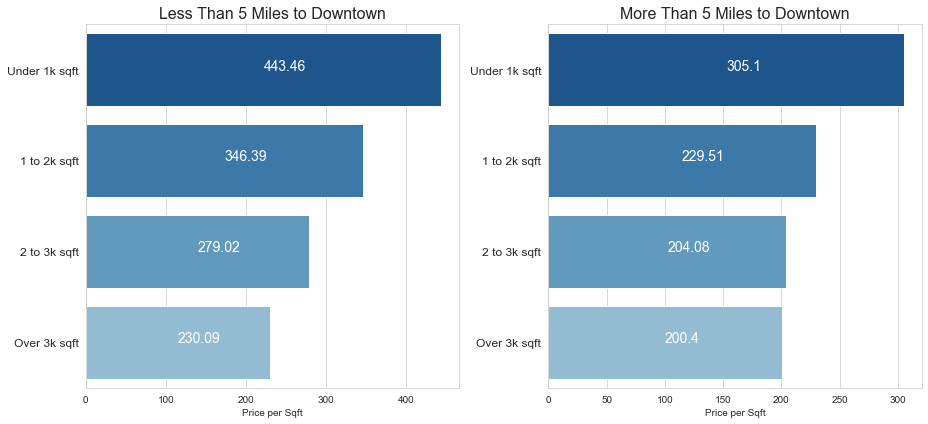

In [87]:
#Create list of sqft bins and median prices
names = ["Under 1k sqft", "1 to 2k sqft", "2 to 3k sqft", "Over 3k sqft"]
medians_5 = [sqft_under1k_5.price_sqft.median(), sqft_1to2k_5.price_sqft.median(), sqft_2to3k_5.price_sqft.median(), 
           sqft_3kplus_5.price_sqft.median()]

#Plot median price vs. square footage
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
sns.barplot(medians_5, names)
for i in range(len(medians_5)):
    plt.text(x= (medians_5[i]/2), y=i, s=round(medians_5[i], 2), c='white', fontsize=14)
plt.title('Less Than 5 Miles to Downtown', fontsize=16)
plt.xlabel('Price per Sqft')
plt.yticks(fontsize=12)

#List of sqft bins further than 5 miles from downtown
medians = [sqft_under1k.price_sqft.median(), sqft_1to2k.price_sqft.median(), sqft_2to3k.price_sqft.median(), 
           sqft_3kplus.price_sqft.median()]

#Plot median price vs. square footage
plt.subplot(1, 2, 2)
for i in range(len(medians)):
    plt.text(x= (medians[i]/2), y=i, s=round(medians[i], 2), c='white', fontsize=14)
sns.barplot(medians, names)
plt.title('More Than 5 Miles to Downtown', fontsize=16)
plt.xlabel('Price per Sqft')
plt.yticks(fontsize=12)
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.savefig('Images/Question2b.png')
plt.show()

This graph clearly shows us that smaller homes typically have a higher price per square foot in both homes within 5 miles to downtown and further than 5 miles from downtown. When selling a home, it is important to be careful comparing smaller homes to larger ones as the price per square foot can differ drastically.

### Question 3: How do building grade and age of the home relate?

Below are the building grade score descriptions pulled from the King County site:
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc. 

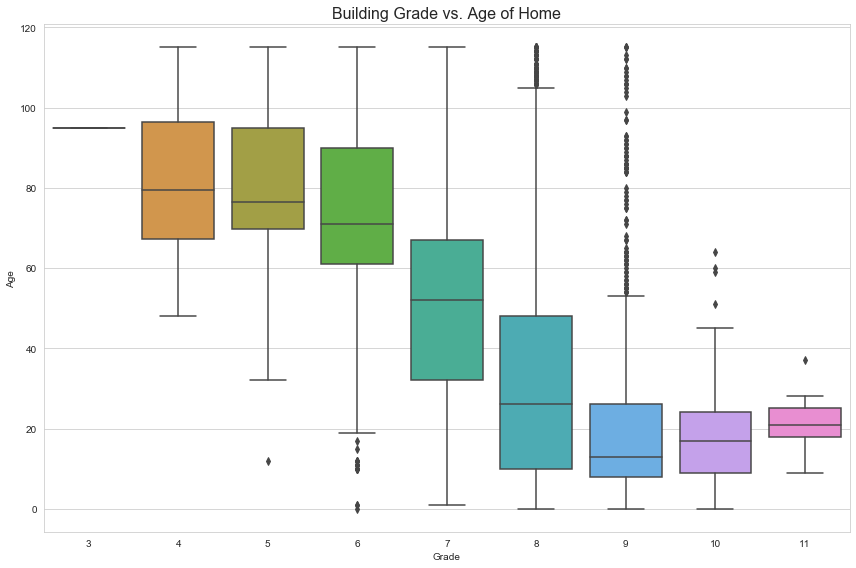

In [88]:
#Plot building grade vs. age
plt.figure(figsize=(12, 8))
sns.boxplot(df.grade, df.age)
plt.title('Building Grade vs. Age of Home', fontsize=16)
plt.xlabel('Grade')
plt.ylabel('Age')
plt.tight_layout()
plt.savefig('Images/Question3a')
plt.show()

Although not always the case (as shown by the outliers in this plot), it's not unusual to see that for the most part, the older the home the lower the building grade. From grade 3 to 7, the median age is over 50. From grades 8 and up, the median age is under 30 years old. 

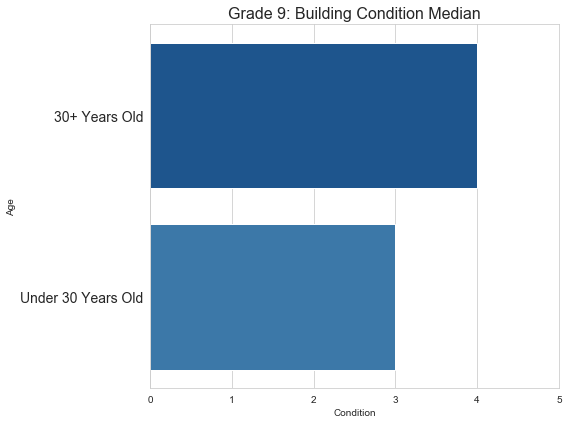

In [89]:
grade_9_30plus = df[(df['grade'] == 9) & (df['age'] >= 30)]
grade_9_below30 = df[(df['grade'] == 9) & (df['age'] < 30)]

cond_medians = [grade_9_30plus.condition.median(), grade_9_below30.condition.median()]
x_labels = ["30+ Years Old", "Under 30 Years Old"]

plt.figure(figsize=(8, 6))
sns.barplot(cond_medians, x_labels)
plt.title('Grade 9: Building Condition Median', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(range(0, 6))
plt.xlabel('Condition')
plt.ylabel('Age')
plt.tight_layout()
plt.savefig('Images/Question3b')
plt.show()

Diving into the multiple outliers in grade 9, an explanation for this is that although these homes are older than 30 years, they have a median building condition of 4 compared to the homes under 30 years with a median condition of 3. The higher condition for these homes is a sign of a lower effective age as described on the King County government website. If you're selling an older home, upkeep and renovations become important and almost necessary in some cases if you want to keep the effective age lower and increase the value of your home significantly.

Ultimately, these questions help build the case for the need for a multiple linear regression model as their are multiple features affecting the sale price of a home, and one feature alone can't predict prices accurately.